In [2]:
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
%matplotlib inline
plt.style.use('fivethirtyeight')
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['lines.linewidth'] = 1.5
darkgrey = '#3A3A3A'
lightgrey = '#414141'
barblue = plt.rcParams['axes.prop_cycle'].by_key()['color'][0]
plt.rcParams['text.color'] = darkgrey
plt.rcParams['axes.labelcolor'] = darkgrey
plt.rcParams['xtick.color'] = lightgrey
plt.rcParams['ytick.color'] = lightgrey

# Forecasting Feasible Scope with a Monte Carlo Simulation 'How Many'
## Context
At our planning on 28th January 2018 Jacob remarked that the planned scope of 7 items is maybe too large for the next 14-day sprint. Before we make a commitment for this scope and delivery date, we have to forecast the probability to complete the items in time.

## Idea

To understand the current delivery capability, we tracked our throughput and cycle times of our items in the issue tracking tool [Jira](https://de.atlassian.com/software/jira). We can use this data to forecast future throughput. 

The measurement took place between 13th July 2018 and 30th January 2019. The results were exported into a CSV file using the [Jira-to-Analytics](https://github.com/ActionableAgile/jira-to-analytics) command line tool with the following configuration:
```
[...]
Criteria:
    Project: 
        - DATA
    Issue types: 
        - Story
        - Task
        - Bug
    Start Date: 2018-07-13
    End Date: 2019-01-30

Workflow:
[...]

```
The CSV file contains all items that were created and moved through during the measurement. We just take the relevant data of completed items: completion date and type

In [3]:
kanban_data = pd.read_csv('data.csv', usecols=['Done', 'Type'], parse_dates=['Done']).dropna()
kanban_data.head(1)

,Done,Type
0,2018-09-26,Story


## Analysis

Based on the past throughput per day a forecast can be created with a Monte Carlo simulation. Throughput is the number of total items completed per day.

### Calculate Throughput
Therefore, we sum up the completed items per day and add the missing dates with zero throughput. We plot the data of the throughput per day to get a brief overview of the result.

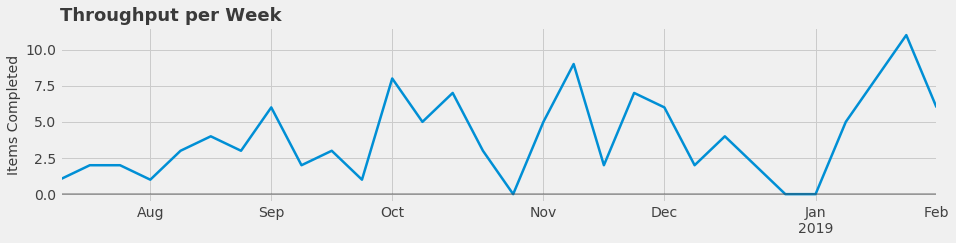

In [4]:
throughput = pd.crosstab(
    kanban_data.Done, kanban_data.Type, colnames=[None]).reset_index()
throughput['Throughput'] = throughput.Bug + throughput.Story + throughput.Task
date_range = pd.date_range(
    start=throughput.Done.min(), end=throughput.Done.max())
throughput = throughput.set_index('Done').reindex(
    date_range).fillna(0).astype(int).rename_axis('Date')
throughput_per_week = pd.DataFrame(
    throughput['Throughput'].resample('W-Mon').sum()).reset_index()
ax = throughput_per_week.plot(
    x='Date', y='Throughput', linewidth=2.5, figsize=(14, 3), legend=None)
ax.set_title("Throughput per Week", loc='left', fontdict={
             'fontsize': 18, 'fontweight': 'semibold'})
ax.set_xlabel('')
ax.set_ylabel('Items Completed')
ax.axhline(y=0, color=lightgrey, alpha=.5);

### Run Monte Carlo Simulation 'How Many'
Based on the throughput data we simulate multiple times how many items can be completed in the given time span. Before we run the simulation we set the configuration values:
* Date range of data basis (last days)
* Number of items to simulate.
* Number of simulations to run (Recommendation: >= 10000).

We plot the simulation results to get a brief overview of distribution of total items completed in the given timespan.

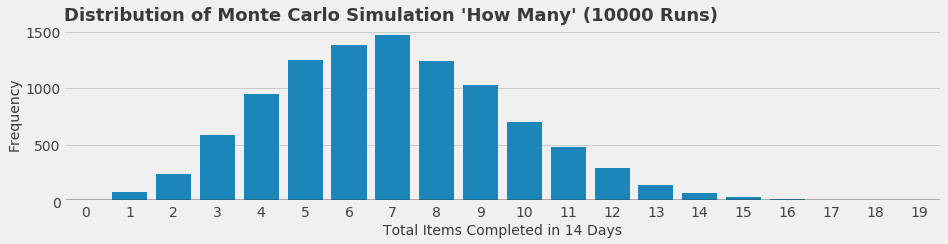

In [5]:
### SETTINGS ####
LAST_DAYS = 100
SIMULATION_DAYS = 14
SIMULATIONS = 10000
###
dataset = throughput[['Throughput']][: LAST_DAYS].reset_index(drop=True)
samples = [dataset.sample(n=SIMULATION_DAYS, replace=True).sum(
).Throughput for i in range(SIMULATIONS)]
samples = pd.DataFrame(samples, columns=['Items'])
distribution = samples.groupby(['Items']).size().reset_index(name='Frequency')
plt.figure(figsize=(14, 3))
ax = sns.barplot(x='Items', y='Frequency', data=distribution, color=barblue)
ax.set_title(f"Distribution of Monte Carlo Simulation 'How Many' ({SIMULATIONS} Runs)", loc='left',
             fontdict={'size': 18, 'weight': 'semibold'})
ax.set_xlabel(f"Total Items Completed in {SIMULATION_DAYS} Days")
ax.set_ylabel('Frequency')
ax.axhline(y=SIMULATIONS*0.001, color=darkgrey, alpha=.5);

### Analysis of the Probabilities of Occurrence
We determine the probability for each number of completed items by cumulating the frequency in the simulations. We plot the probability for each number of completed items and indicate the percentiles 70%, 85%, and 95%.

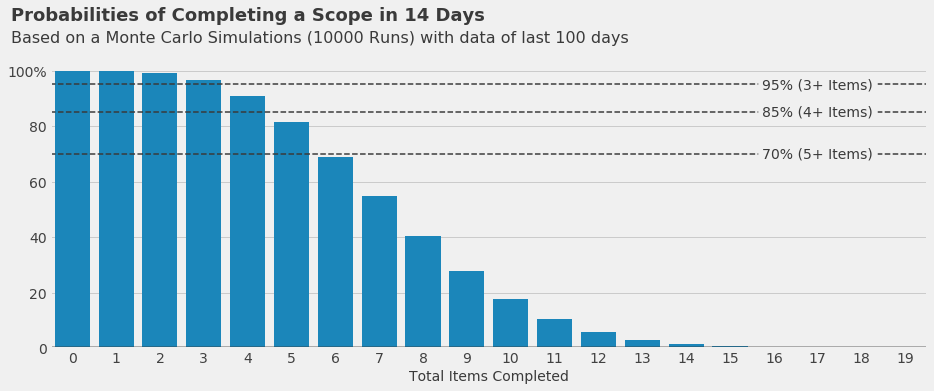

In [6]:
distribution = distribution.sort_index(ascending=False)
distribution['Probability'] = 100 * \
    distribution.Frequency.cumsum()/distribution.Frequency.sum()
plt.figure(figsize=(14, 5))
ax = sns.barplot(x='Items', y='Probability', data=distribution, color=barblue)
ax.text(x=-1.4, y=118,
        s=f"Probabilities of Completing a Scope in {SIMULATION_DAYS} Days", fontsize=18, fontweight='semibold')
ax.text(x=-1.4, y=110,
        s=f"Based on a Monte Carlo Simulations ({SIMULATIONS} Runs) with data of last {LAST_DAYS} days", fontsize=16)
ax.set_ylabel('')
ax.set_xlabel('Total Items Completed')
ax.axhline(y=0.5, color=darkgrey, alpha=.5)
ax.axhline(y=70, color=darkgrey, linestyle='--')
ax.axhline(y=85, color=darkgrey, linestyle='--')
ax.axhline(y=95, color=darkgrey, linestyle='--')
label_xpos = distribution['Items'].max()-2
ax.text(y=70, x=label_xpos, s=f'70%% (%d+ Items)' % samples.Items.quantile(0.3),
        va='center', ha='center', backgroundcolor='#F0F0F0')
ax.text(y=85, x=label_xpos, s=f'85%% (%d+ Items)' % samples.Items.quantile(0.15),
        va='center', ha='center', backgroundcolor='#F0F0F0')
ax.text(y=95, x=label_xpos, s=f'95%% (%d+ Items)' % samples.Items.quantile(0.05),
        va='center', ha='center', backgroundcolor='#F0F0F0')
ax.set_yticklabels(labels=['0', '20', '40', '60', '80', '100%']);

## Conclusion
With a 60% probability of occurrence a scope of 7 items in 14 days is risky and the scope should be reduced to at least 5-6 items to meet the 70% percentile.